In [3]:
import os
import re
import shutil
import sys
from dataclasses import dataclass, field

import evaluate
import pandas as pd
import torch
import torchaudio
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, Subset
from tqdm.auto import tqdm
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import evaluate
import os
import soundfile as sf
import numpy as np
import json

/home/geyu/projects/my-test/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Training

Preprocessing

1. Load the audio from corresponding path
2. resample the audio to 16kHz
3. Ensure the audio is mono channel, if not, take the mean of the channels
4. using wav2vec processor to process the audio since we only finetuning on English, hence no special tokenizer need to be use. 
5. remove all punctuation from the transcription and use upper case (match the original training data style)
6. Remove the audio that longer than 20 seconds, to prevent OOM

Training

The learning rate is selected by sub-sample the validation samples, and run for a few hundrud steps. Use the learning rate that has the best convergence and best validation wer. 

Batch size is selected that largest to fit the GPU VRAM

Early stop criteria is applied if the validation performance is not increasing with 3 times tolerance, this is to prevent overfitting. 

Use fp16 mix precision training in order to speed up the training, and use larger batch size.


In [ ]:
ROOT_DIR = '../data'
TRAIN_INDICES = pd.read_csv(f'{ROOT_DIR}/cv-valid-train.csv')
TRAIN_DATA_BASE = f"{ROOT_DIR}/cv-valid-train"

# TRAIN_INDICES = TRAIN_INDICES.sample(frac=0.01, random_state=42)

TEST_INDICES = pd.read_csv(f'{ROOT_DIR}/cv-valid-test.csv')
TEST_DATA_BASE = f"{ROOT_DIR}/cv-valid-test"

'''
1. Load the audio from corresponding path
2. resample the audio to 16kHz
3. Ensure the audio is mono channel, if not, take the mean of the channels
4. using wav2vec processor to process the audio
5. remove all punctuation from the transcription (match the original training data style)
6. Remove the audio that longer than 20 seconds, to prevent OOM
'''
class AudioDataset(Dataset):
    def __init__(self, dataframe, processor, audio_base_path):
        self.dataframe = dataframe
        self.processor = processor
        self.audio_base_path = audio_base_path
        self.chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"“%”\\\]'

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        audio_filename = row['filename']
        text = row['text']

        # Construct full audio file path
        audio_path = os.path.join(self.audio_base_path, audio_filename)

        # Load audio file
        try:
            speech_array, sampling_rate = torchaudio.load(audio_path)
        except Exception as e:
            print(f"Error loading audio file {audio_path}: {e}")
            return None # Return None for problematic samples, will be filtered by collator

        # Resample if necessary (Wav2Vec2 expects 16kHz)
        if sampling_rate != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sampling_rate, new_freq=16000)
            speech_array = resampler(speech_array)
        
        # Ensure mono audio
        if speech_array.shape[0] > 1:
            speech_array = speech_array.mean(dim=0, keepdim=True)

        if len(speech_array.squeeze(0)) > 16000 * 20:  # If audio is longer than 20 seconds
            print(f"Audio file {audio_path} is too long, skipping.")
            return None
            
        # Process audio (normalize, etc.)
        # Squeeze to remove the channel dimension (e.g., from (1, samples) to (samples,))
        input_values = self.processor(speech_array.squeeze(0).numpy(), sampling_rate=16000).input_values[0]

        # Clean and tokenize text
        text = re.sub(self.chars_to_ignore_regex, '', text).upper()
        
        
        # print(text)
        return {"input_values": input_values, "labels": text}
    
class DataCollatorCTCWithPadding:
    def __init__(self, processor, padding=True):
        
        self.processor = processor
        self.padding = padding

    def __call__(self, features):
        # Filter out None values from __getitem__
        features = [f for f in features if f is not None]
        if not features: # If all features were None, return empty batch
            return None
        # print(self.processor.tokenizer.encode(features[0]['labels']))
        # Separate input_values and labels
        input_features = [feature["input_values"] for feature in features]
        label_features = [feature["labels"] for feature in features]
   
        batch = self.processor(
            input_features,
            padding=self.padding,
            sampling_rate=16000,
            return_tensors="pt",
        )
  
        labels_batch = self.processor(
            text = label_features,
            padding=self.padding,
            return_tensors="pt",
        )
        # print(labels_batch['input_ids'])
        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100
        )

        batch["labels"] = labels

        return batch

'''
The learning rate is selected by sub-sample the validation samples, and run for a few hundrud steps. Use the learning rate that has the best convergence and best validation wer. 

Batch size is selected that largest to fit the GPU VRAM
'''

def train(run_final_validation: bool = True):
    MODEL_NAME = "facebook/wav2vec2-large-960h"
    processor = Wav2Vec2Processor.from_pretrained(MODEL_NAME, sampling_rate=16000, ctc_loss_reduction="mean")
    model = Wav2Vec2ForCTC.from_pretrained(MODEL_NAME)
    RANDOM_STATE = 42 # to ensure reproducibility
    TRAIN_SPLIT_RATIO = 0.7
    LEARNING_RATE = 1e-5
    TRAIN_BATCH_SIZE = 16
    VAL_BATCH_SIZE = 32
    NUM_EPOCHS = 10
    # EVAL_STEP: Controls how often validation is run and metrics are evaluated
    EVAL_STEP = 1000
    # LOG_STEP: Controls how often training loss is logged to console
    LOG_STEP = 50 # Log training loss every 50 steps
    GRADIENT_ACCUMULATION_STEPS = 1
    MAX_STEP_CHECKPOINTS = 3 # Maximum number of step checkpoints to keep
    EARLY_STOP_PATIENCE = 3 # Number of validation checks to wait before early stopping

    # Adjust EVAL_STEP to account for gradient accumulation
    EVAL_STEP = EVAL_STEP * GRADIENT_ACCUMULATION_STEPS
    print(f"Using gradient accumulation with {GRADIENT_ACCUMULATION_STEPS} steps, effective EVAL_STEP for validation is now {EVAL_STEP}")

    # Lists to store metrics
    # train_losses_logged will store training loss averaged over LOG_STEP intervals
    train_losses_logged = []
    # train_losses_at_eval will store training loss averaged over EVAL_STEP intervals (for comparison with validation)
    train_losses_at_eval = []
    val_losses = []
    val_wer_scores = []
    # log_steps_recorded will correspond to the steps where validation (EVAL_STEP) was performed
    log_steps_recorded = []
    val_results = []

    train_indices, val_indices = train_test_split(
        TRAIN_INDICES, test_size=1-TRAIN_SPLIT_RATIO, random_state=RANDOM_STATE
    )
    # val_indices = val_indices.sample(n=1000, random_state=RANDOM_STATE)  # Limit validation set to 1000 samples
    print(f"Train samples: {len(train_indices)}, Validation samples: {len(val_indices)}")

    # Freeze feature extractor layers
    model.freeze_feature_encoder()

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Using device: {device}")

    train_dataset = AudioDataset(train_indices, processor, TRAIN_DATA_BASE)
    val_dataset = AudioDataset(val_indices, processor, TRAIN_DATA_BASE)

    data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        collate_fn=data_collator,
        num_workers=32, # Set to 0 for simpler debugging, adjust for production
        pin_memory=True,
        shuffle=True
    )
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=VAL_BATCH_SIZE,
        collate_fn=data_collator,
        num_workers=32, # Set to 0 for simpler debugging, adjust for production
        pin_memory=True,
        shuffle=False
    )

    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scaler = torch.cuda.amp.GradScaler() # use mixed presition for speed up

    # Initialize WER metric
    wer_metric = evaluate.load("wer")

    print("\nStarting training...")
    # Accumulators for training loss, separated for LOG_STEP and EVAL_STEP
    accumulated_loss_for_log_step = 0 # For logging train loss more frequently
    batches_in_log_interval = 0

    accumulated_loss_for_eval_step = 0 # For calculating train loss at validation points

    # Initialize variables for best model saving
    best_wer = float('inf')
    model_save_base_path = "../models/checkpoints"
    os.makedirs(model_save_base_path, exist_ok=True) # Ensure base directory exists
    best_model_save_path = os.path.join(model_save_base_path, "best_model")

    # List to keep track of saved step checkpoint paths for rotation
    saved_step_checkpoints = []

    # Early stopping variables
    epochs_no_improve = 0
    early_stop = False
    
    # Track the last step reached for potential final validation
    last_step_reached = 0

    for epoch in range(NUM_EPOCHS):
        if early_stop:
            print("Early stopping triggered.")
            break

        # --- Training Phase ---
        model.train()
        total_train_loss_epoch = 0 # For overall epoch average train loss
        optimizer.zero_grad() # Ensure gradients are zeroed at the start of each epoch

        for i, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1} Training", file=sys.stdout)):
            current_step = (epoch * len(train_dataloader)) + (i + 1)
            last_step_reached = current_step # Update last step reached

            batch = {k: v.to(device) for k, v in batch.items()}

            with torch.cuda.amp.autocast():
                outputs = model(input_values=batch["input_values"], labels=batch["labels"])
            loss = outputs.loss
            # Scale the loss by the number of accumulation steps
            scaled_loss = loss / GRADIENT_ACCUMULATION_STEPS
            scaler.scale(scaled_loss).backward()

            # Accumulate loss for epoch average
            total_train_loss_epoch += loss.item()

            # Accumulate loss for logging at LOG_STEP intervals
            accumulated_loss_for_log_step += loss.item()
            batches_in_log_interval += 1

            # Accumulate loss for logging at EVAL_STEP intervals
            accumulated_loss_for_eval_step += loss.item()

            # Perform optimizer step and zero gradients only after accumulating enough gradients
            if current_step % GRADIENT_ACCUMULATION_STEPS == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad() # Zero gradients after the optimizer step

            # --- Logging Training Loss (Every LOG_STEP) ---
            if current_step % LOG_STEP == 0:
                # Calculate average accumulated loss over the LOG_STEP interval
                avg_train_loss_current_log_interval = accumulated_loss_for_log_step / batches_in_log_interval
                train_losses_logged.append(avg_train_loss_current_log_interval)
                print(f"Step {current_step} - Train Loss (last {batches_in_log_interval} batches): {avg_train_loss_current_log_interval:.4f}")
                # Reset accumulator for the next LOG_STEP interval
                accumulated_loss_for_log_step = 0
                batches_in_log_interval = 0

            # --- Validation and WER Calculation Phase (Every EVAL_STEP) ---
            if current_step % EVAL_STEP == 0:
                # Calculate average training loss over the EVAL_STEP interval
                # Divide by the actual number of batches in the EVAL_STEP interval
                current_train_loss_for_eval = accumulated_loss_for_eval_step / (EVAL_STEP / GRADIENT_ACCUMULATION_STEPS)
                train_losses_at_eval.append(current_train_loss_for_eval)
                accumulated_loss_for_eval_step = 0 # Reset for next EVAL_STEP

                model.eval() # Set model to evaluation mode
                total_val_loss = 0
                all_preds = []
                all_labels = []

                with torch.no_grad():
                    # Ensure tqdm prints to sys.stdout for consistency
                    for val_batch in tqdm(val_dataloader, desc=f"Step {current_step} Validation", file=sys.stdout):
                        val_batch = {k: v.to(device) for k, v in val_batch.items()}
                        outputs = model(input_values=val_batch["input_values"], labels=val_batch["labels"])
                        val_loss = outputs.loss
                        total_val_loss += val_loss.item()

                        # Calculate WER
                        logits = outputs.logits
                        pred_ids = torch.argmax(logits, dim=-1)

                        # Replace -100 in labels with processor.tokenizer.pad_token_id
                        val_batch["labels"][val_batch["labels"] == -100] = processor.tokenizer.pad_token_id

                        # Decode predictions and labels
                        predictions = processor.batch_decode(pred_ids)
                        references = processor.batch_decode(val_batch["labels"], group_tokens=False)

                        all_preds.extend(predictions)
                        all_labels.extend(references)

                avg_val_loss = total_val_loss / len(val_dataloader)
                val_losses.append(avg_val_loss)

                # Compute WER for the entire validation set at this eval step
                wer_score = wer_metric.compute(predictions=all_preds, references=all_labels)
                val_wer_scores.append(wer_score)
                val_results.append({
                    "step": current_step,
                    "validation_loss": avg_val_loss,
                    "wer": wer_score,
                    "predictions": all_preds,
                    "references": all_labels
                })
                log_steps_recorded.append(current_step) # These steps correspond to validation runs

                print(f"Step {current_step} - Train Loss (avg over last {EVAL_STEP} batches): {current_train_loss_for_eval:.4f} - Validation Loss: {avg_val_loss:.4f} - Validation WER: {wer_score:.4f}")

                # --- Early Stopping Logic ---
                if wer_score < best_wer:
                    best_wer = wer_score
                    epochs_no_improve = 0
                    # Create directory for the best model if it doesn't exist
                    os.makedirs(best_model_save_path, exist_ok=True)
                    model.save_pretrained(best_model_save_path)
                    processor.save_pretrained(best_model_save_path)
                    print(f"New best model saved at step {current_step} with WER: {best_wer:.4f} to {best_model_save_path}")
                else:
                    epochs_no_improve += 1
                    print(f"Validation WER did not improve for {epochs_no_improve} times.")
                    if epochs_no_improve >= EARLY_STOP_PATIENCE:
                        print(f"Early stopping: Validation WER has not improved for {EARLY_STOP_PATIENCE} consecutive validation checks. Stopping training.")
                        early_stop = True
                        break # Break from the inner loop (training steps)

                # --- Save model at every evaluation step (with rotation) ---
                current_step_model_path = os.path.join(model_save_base_path, f"model_step_{current_step}")
                os.makedirs(current_step_model_path, exist_ok=True)
                model.save_pretrained(current_step_model_path)
                processor.save_pretrained(current_step_model_path)
                print(f"Model saved for step {current_step} to {current_step_model_path}")

                # Add the new checkpoint path to the list
                saved_step_checkpoints.append(current_step_model_path)

                # If more than MAX_STEP_CHECKPOINTS are saved, remove the oldest one
                if len(saved_step_checkpoints) > MAX_STEP_CHECKPOINTS:
                    oldest_checkpoint_path = saved_step_checkpoints.pop(0) # Remove the oldest path
                    if os.path.exists(oldest_checkpoint_path):
                        shutil.rmtree(oldest_checkpoint_path) # Delete the directory
                        print(f"Removed oldest checkpoint: {oldest_checkpoint_path}")

                model.train() # Set model back to training mode

        # Handle any remaining gradients if the total number of batches is not a multiple of GRADIENT_ACCUMULATION_STEPS
        # and if training is not stopping immediately
        if not early_stop and (current_step % GRADIENT_ACCUMULATION_STEPS != 0):
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        if early_stop: # Check again after the inner loop in case it broke due to early stopping
            break

        avg_train_loss_epoch = total_train_loss_epoch / len(train_dataloader)
        print(f"Epoch {epoch+1} - Average Epoch Train Loss: {avg_train_loss_epoch:.4f}")
    
    print("\nTraining complete!")

    # --- Final Validation (Optional) ---
    if run_final_validation:
        print(f"\nRunning final validation at step {last_step_reached} (controlled by run_final_validation={run_final_validation})...")
        model.eval() # Set model to evaluation mode
        total_val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for val_batch in tqdm(val_dataloader, desc=f"Final Validation", file=sys.stdout):
                val_batch = {k: v.to(device) for k, v in val_batch.items()}
                outputs = model(input_values=val_batch["input_values"], labels=val_batch["labels"])
                val_loss = outputs.loss
                total_val_loss += val_loss.item()

                logits = outputs.logits
                pred_ids = torch.argmax(logits, dim=-1)

                val_batch["labels"][val_batch["labels"] == -100] = processor.tokenizer.pad_token_id

                predictions = processor.batch_decode(pred_ids)
                references = processor.batch_decode(val_batch["labels"], group_tokens=False)

                all_preds.extend(predictions)
                all_labels.extend(references)

        avg_val_loss = total_val_loss / len(val_dataloader)
        wer_score = wer_metric.compute(predictions=all_preds, references=all_labels)

        val_losses.append(avg_val_loss)
        val_wer_scores.append(wer_score)
        val_results.append({
            "step": last_step_reached,
            "validation_loss": avg_val_loss,
            "wer": wer_score,
            "predictions": all_preds,
            "references": all_labels
        })
        log_steps_recorded.append(last_step_reached)

        print(f"Final Validation Results (Step {last_step_reached}): Loss: {avg_val_loss:.4f}, WER: {wer_score:.4f}")
        
        if wer_score < best_wer:
            best_wer = wer_score
            # Create directory for the best model if it doesn't exist
            os.makedirs(best_model_save_path, exist_ok=True)
            model.save_pretrained(best_model_save_path)
            processor.save_pretrained(best_model_save_path)
            print(f"Final best model saved at step {last_step_reached} with WER: {best_wer:.4f} to {best_model_save_path}")

    # The model saved as 'best_model' is the one with the lowest WER throughout training.
    # We explicitly save the final state of the model as 'final_model' as well.
    final_model_save_path = os.path.join(model_save_base_path, "final_model")
    os.makedirs(final_model_save_path, exist_ok=True)
    model.save_pretrained(final_model_save_path)
    processor.save_pretrained(final_model_save_path)
    print(f"Final model saved to {final_model_save_path}")

    # Return the losses appropriate for logging and validation
    return train_losses_logged, val_losses, log_steps_recorded, val_wer_scores, val_results



train_losses, val_losses, log_steps_recorded, val_wer_scores, val_results = train()

with open('./results.json', 'w') as f:
    import json
    json.dump({
        "train_losses": train_losses,
        "val_losses": val_losses,
        "log_steps_recorded": log_steps_recorded,
        "val_wer_scores": val_wer_scores,
        "val_results": val_results
    }, f, indent=4)

/home/geyu/projects/my-test/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [1]:
! mv ../models/checkpoints/best_model ../models/wav2vec2-large-960h-cv

# Visualize Training

In [4]:
with open('./results.json', 'r') as f:
    results = json.load(f)
    
results.keys()

dict_keys(['train_losses', 'val_losses', 'log_steps_recorded', 'val_wer_scores', 'val_results'])

In [5]:
results['val_results'][0].keys()

dict_keys(['step', 'validation_loss', 'wer', 'predictions', 'references'])

In [6]:
steps = [results['val_results'][i]['step'] for i in range(len(results['val_results']))]
val_losses = [results['val_results'][i]['validation_loss'] for i in range(len(results['val_results']))]
train_losses = results['train_losses']
val_wer_scores = results['val_wer_scores']

len(steps), len(val_losses), len(train_losses), len(val_wer_scores)

(35, 35, 680, 35)

In [7]:
import matplotlib.pyplot as plt

def plot_losses_and_wer(train_loss, validation_loss, steps, validation_wer):
    """
    Plots training loss and validation loss on the left subplot,
    and validation Word Error Rate (WER) on the right subplot.

    Args:
        train_loss (list): A list of training loss values, where each value
                           corresponds to a 50-step interval.
        validation_loss (list): A list of validation loss values.
        steps (list): A list of step numbers corresponding to the
                      validation loss and WER values.
        validation_wer (list): A list of validation Word Error Rate values.
    """
    # Basic input validation
    if not train_loss:
        print("Train loss list is empty. Cannot plot training loss.")
        return
    if not validation_loss or not steps:
        print("Validation loss or steps list is empty. Cannot plot validation loss.")
        return
    if len(validation_loss) != len(steps):
        print("Mismatch in length between validation_loss and steps lists.")
        return
    if not validation_wer:
        print("Validation WER list is empty. Cannot plot validation WER.")
        return
    if len(validation_wer) != len(steps):
        print("Mismatch in length between validation_wer and steps lists.")
        return


    # Generate x-axis values for train loss (each at 50-step interval)
    # Assuming the first train_loss value is at step 50, second at 100, and so on.
    train_steps = [(i + 1) * 50 for i in range(len(train_loss))]

    # Create a figure with two subplots arranged side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6)) # 1 row, 2 columns, larger figure size

    # --- Left Subplot: Training and Validation Loss ---
    ax1.plot(train_steps, train_loss, label='Training Loss', marker='o', linestyle='-', markersize=4)
    ax1.plot(steps, validation_loss, label='Validation Loss', marker='x', linestyle='--', markersize=4)

    ax1.set_title('Training and Validation Loss Over Steps')
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    ax1.legend()

    # --- Right Subplot: Validation WER ---
    ax2.plot(steps, validation_wer, label='Validation WER', color='red', marker='s', linestyle='-.', markersize=4)

    ax2.set_title('Validation Word Error Rate Over Steps')
    ax2.set_xlabel('Steps')
    ax2.set_ylabel('Word Error Rate (WER)')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout() # Adjust layout to prevent subplots from overlapping
    plt.show() # Display the plots

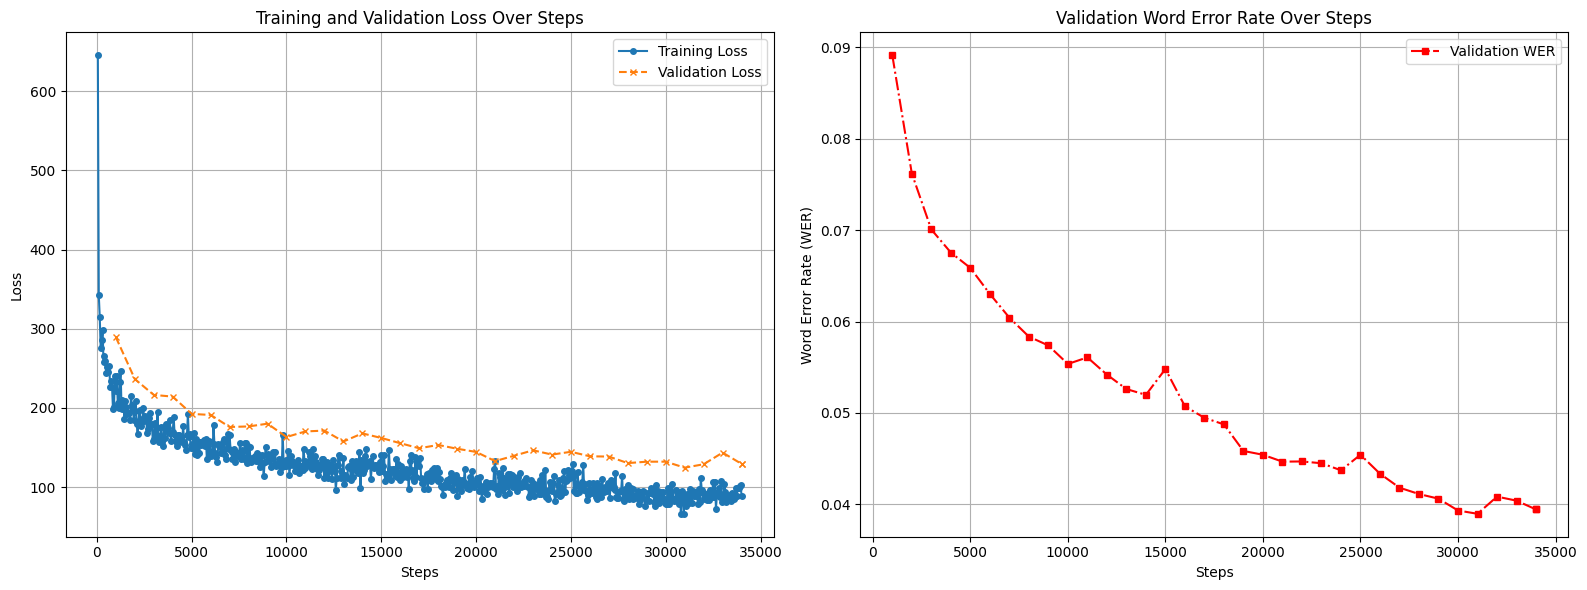

In [8]:
plot_losses_and_wer(train_losses, validation_loss=val_losses, steps=steps, validation_wer=val_wer_scores)

## Interpretation

A decreasing training loss with a flat validation loss often suggests the model is starting to overfit the training data. It's learning the training examples very well, possibly memorizing them, but this learning isn't translating to better performance on unseen validation data.

However, the validation WER (Word Error Rate) still dropping is a positive sign. This indicates the model is genuinely improving its ability to accurately transcribe speech on unseen data, even if the general loss metric isn't showing a steep decline. It suggests the model is effectively learning features relevant to speech recognition, especially for the Common Voice domain, despite the loss function being less sensitive to these improvements at this stage.

# Evaluation

In [9]:
device = 'cuda'
wer_metric = evaluate.load("wer")

MODEL = 'facebook/wav2vec2-base-960h'

In [10]:
origin_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h").to(device)
origin_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")

/home/geyu/projects/my-test/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/geyu/projects/my-test/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
ROOT_DIR = '../data'
TEST_INDICES = pd.read_csv(f'{ROOT_DIR}/cv-valid-test.csv')
TEST_DATA_BASE = f"{ROOT_DIR}/cv-valid-test"

In [12]:
def transcribe(file, eval_model, processor):
    # try:
    # Load audio file with soundfile
    audio_array, sample_rate = sf.read(file)
    
    # Convert to mono if stereo
    if len(audio_array.shape) > 1:
        audio_array = audio_array.mean(axis=1)
    
    # Resample to 16kHz if needed
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        audio_array = torch.from_numpy(audio_array).float()
        audio_array = resampler(audio_array).numpy()
        sample_rate = 16000
    
    # Get duration
    
    # Normalize audio array
    audio_array = audio_array / np.max(np.abs(audio_array))
    
        # Process audio with Wav2Vec2
    input_values = processor(
        audio_array, 
        return_tensors="pt", 
        padding="longest",
        sampling_rate=sample_rate
    ).input_values.to(device)

    # Get model predictions
    with torch.no_grad():
        logits = eval_model(input_values).logits
        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = processor.batch_decode(predicted_ids)[0]


    return transcription


In [13]:
def evaluate_model(eval_model, eval_processor, data_base, data_indices):
    references, predictions = [], []
    for i in tqdm(range(len(data_indices))):
        row = data_indices.iloc[i]
        file_path = f"{data_base}/{row['filename']}"
        
        if not os.path.exists(file_path):
            print(f"File {file_path} does not exist.")
            continue
        
        transcription = transcribe(file_path, eval_model, eval_processor)
        
        # print(transcription)
        # print(row)
        references.append(row['text'].upper())
        predictions.append(transcription)
        # break

    performance = wer_metric.compute(predictions=predictions, references=references)
    print(f"Word Error Rate: {performance:.4f}")    
    return performance


In [14]:
FINTUNED_MODEL = '../models/wav2vec2-large-960h-cv'
cv_model = Wav2Vec2ForCTC.from_pretrained(FINTUNED_MODEL).to(device)
cv_processor = Wav2Vec2Processor.from_pretrained(FINTUNED_MODEL)

/home/geyu/projects/my-test/.venv/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


# Test eval

In [15]:
wer_origin = evaluate_model(origin_model, origin_processor, TEST_DATA_BASE, TEST_INDICES)
wer_finetuned = evaluate_model(cv_model, cv_processor, TEST_DATA_BASE, TEST_INDICES)

 29%|██▉       | 1152/3995 [00:29<01:11, 39.76it/s]/tmp/ipykernel_3277243/4231139856.py:20: RuntimeWarning: invalid value encountered in divide
  audio_array = audio_array / np.max(np.abs(audio_array))
100%|██████████| 3995/3995 [02:27<00:00, 27.06it/s]


Word Error Rate: 0.1026


100%|██████████| 3995/3995 [02:08<00:00, 31.01it/s]


Word Error Rate: 0.0393


In [16]:
print(f"WER for original model: {wer_origin:.4f}")
print(f"WER for finetuned model: {wer_finetuned:.4f}")

WER for original model: 0.1026
WER for finetuned model: 0.0393


# Dev eval

In [17]:
DEV_INDICES = pd.read_csv(f'{ROOT_DIR}/cv-valid-dev.csv')
DEV_DATA_BASE = f"{ROOT_DIR}/cv-valid-dev"

In [18]:
wer_origin = evaluate_model(origin_model, origin_processor, DEV_DATA_BASE, DEV_INDICES)
wer_finetuned = evaluate_model(cv_model, cv_processor, DEV_DATA_BASE, DEV_INDICES)

 34%|███▎      | 1374/4076 [00:33<01:09, 38.81it/s]/tmp/ipykernel_3277243/4231139856.py:20: RuntimeWarning: invalid value encountered in divide
  audio_array = audio_array / np.max(np.abs(audio_array))
100%|██████████| 4076/4076 [01:39<00:00, 41.13it/s]


Word Error Rate: 0.1081


100%|██████████| 4076/4076 [01:39<00:00, 41.05it/s]


Word Error Rate: 0.0424
